There are currently 128 other columns outside of 'hr_mean' that we can potentially use as features. I decided to do a feature analysis via random forest to understand the most important features out of the 128, that predict heart rate. We can then use these features as inputs for our wide variety machine learning models. Once we perform the feature analysis, we aim to do cumulative importance. 
This method involves selecting the top features whose cumulative importance reaches a certain percentage of the total (often around 95-99%).
It ensures that you retain the most significant contributors to the model's performance while potentially omitting features that contribute little to overall accuracy.
This approach is particularly useful when there are many features with small individual importances which cumulatively might be significant.

Considerations for feature analysis:
1. Timestamps can not be considered in their raw state:
* Non-Predictive Nature: Raw timestamps are unique to each instance and don't typically have a predictive relationship with the target variable in their raw form. They represent when the data was collected rather than being an inherent characteristic of the observations.

* High Cardinality: Timestamps can introduce high cardinality (i.e., a large number of unique values) which is not useful for most machine learning models and can lead to overfitting, where the model learns patterns specific to the training data that don't generalize.

* Time-related Features: Instead of using raw timestamps, derived features that capture time-related patterns are more beneficial. For example, extracting the hour of the day, day of the week, month, or even time since a particular event are more likely to have a predictive relationship with the target variable. These derived features can capture cyclical patterns in behavior or environmental changes that might affect the target variable.
    * Derived features like day of week, month or even time are not relevant for this data since participant data is collected in a few hours in one day. So I reasoned that using those features are not very relevant so instead I used minutes to see if it can provide a more granular and potentially more relevant feature.
      
#Code Cell Description:


Your code for loading, preprocessing, and preparing a dataset for a machine learning model appears comprehensive and well-structured. Here are some key points to consider:

Loading and Preprocessing:

The dataset is loaded from an Excel file and processed sheet by sheet.
We've added sheet_name as a feature, which can be useful if the sheet name has some contextual significance.
The minutes_since_start feature is a great addition, as it could capture time-related trends in the data.
We've also performed one-hot encoding on the Label column and mapped task orders, which should help the model understand categorical data better.
Data Splitting:

The dataset is split into training, validation, and test sets, which is good practice for evaluating the model's performance.


Handling Numeric and Non-Numeric Data:

Separating numeric and non-numeric data is a thoughtful approach. It allows for tailored preprocessing for each data type.
Imputing missing values and scaling numeric data are crucial steps to prepare the data for a model.
One-Hot Encoding for Non-Numeric Data:

We've handled non-numeric data by filling NaNs and one-hot encoding. Ensure that the same columns are encoded in training, validation, and test sets to maintain consistency.

Final Checks and Validation:
We've recombined the processed numeric and non-numeric data and checked for any non-numeric data in the training set, ensuring that the data is ready for modeling.


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Load the dataset
file_path = 'data-for-predicting-hr.xlsx'
excel_data = pd.ExcelFile(file_path)

# Given list of labels in order
labels_in_order = [
    "P1S1", "Transit", "P1S2", "Transit", "P1S3", "Transit", "P1S4", "Transit", "P1S5",
    "Transit", "P2S1", "Transit", "P2S2", "Transit", "P2S3", "Transit", "P2S4", "Transit", "P2S5",
    "Transit", "P3S1", "Transit", "P3S2", "Transit", "P3S3", "Transit", "P3S4",
    "Transit", "P4S1", "Transit", "P4S2", "Transit", "P4S3", "Transit", "P4S4",
    "Transit", "P5S1", "Transit", "P5S2", "Transit", "P5S3", "Transit", "P5S4", "Transit", "P5S5"
]

# Create task sequence order dictionary
task_order = {label: i + 1 for i, label in enumerate(labels_in_order)}

# Read and preprocess each sheet
all_data = []
for sheet_name in excel_data.sheet_names:
    df = excel_data.parse(sheet_name=sheet_name)
    
    # Add sheet name as a column
    df['sheet_name'] = sheet_name
    # Feature Engineering: Calculating minutes since the start of the session
    start_time = df['CanadianTS'].min()  # assuming the first timestamp is the start
    df['minutes_since_start'] = (df['CanadianTS'] - start_time).dt.total_seconds() / 60.0

    # One-hot encoding the 'Label' column
    label_dummies = pd.get_dummies(df['Label'], prefix='Label')
    df = pd.concat([df, label_dummies], axis=1)
    
    # Task sequence encoding
    df['task_order'] = df['Label'].map(task_order)

    # Drop 'Label' and 'CanadianTS' as we won't use them anymore
    df = df.drop(columns=['Label', 'CanadianTS'])

    all_data.append(df)

combined_df = pd.concat(all_data, ignore_index=True)
combined_df = combined_df.dropna(subset=['hr_mean'])

preliminary_features = [col for col in combined_df.columns if col != 'hr_mean']

# Splitting the dataset
X_train, X_temp, y_train, y_temp = train_test_split(combined_df[preliminary_features], combined_df['hr_mean'], test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Separate numeric and non-numeric data
X_train_numeric = X_train.select_dtypes(include=[np.number])
X_train_non_numeric = X_train.select_dtypes(exclude=[np.number])

X_val_numeric = X_val.select_dtypes(include=[np.number])
X_val_non_numeric = X_val.select_dtypes(exclude=[np.number])

X_test_numeric = X_test.select_dtypes(include=[np.number])
X_test_non_numeric = X_test.select_dtypes(exclude=[np.number])

# Reset index for numeric and non-numeric data to align them correctly
X_train_numeric.reset_index(drop=True, inplace=True)
X_train_non_numeric.reset_index(drop=True, inplace=True)
X_val_numeric.reset_index(drop=True, inplace=True)
X_val_non_numeric.reset_index(drop=True, inplace=True)
X_test_numeric.reset_index(drop=True, inplace=True)
X_test_non_numeric.reset_index(drop=True, inplace=True)


# Handle NaNs in non-numeric data
X_train_non_numeric.fillna('Unknown', inplace=True)
X_val_non_numeric.fillna('Unknown', inplace=True)
X_test_non_numeric.fillna('Unknown', inplace=True)

# One-hot encoding for non-numeric data (if not already done)
# Assuming 'sheet_name' and other categorical columns need encoding
X_train_non_numeric_encoded = pd.get_dummies(X_train_non_numeric)
X_val_non_numeric_encoded = pd.get_dummies(X_val_non_numeric)
X_test_non_numeric_encoded = pd.get_dummies(X_test_non_numeric)

# Impute numeric data
imputer = SimpleImputer(strategy='mean')
X_train_numeric_imputed = imputer.fit_transform(X_train_numeric)
X_val_numeric_imputed = imputer.transform(X_val_numeric)
X_test_numeric_imputed = imputer.transform(X_test_numeric)

# Scale the numeric data
scaler = StandardScaler()
X_train_numeric_scaled = scaler.fit_transform(X_train_numeric_imputed)
X_val_numeric_scaled = scaler.transform(X_val_numeric_imputed)
X_test_numeric_scaled = scaler.transform(X_test_numeric_imputed)

# Convert the scaled numeric data back to a DataFrame
X_train_numeric_scaled_df = pd.DataFrame(X_train_numeric_scaled, columns=X_train_numeric.columns, index=X_train_numeric.index)
X_val_numeric_scaled_df = pd.DataFrame(X_val_numeric_scaled, columns=X_val_numeric.columns, index=X_val_numeric.index)
X_test_numeric_scaled_df = pd.DataFrame(X_test_numeric_scaled, columns=X_test_numeric.columns, index=X_test_numeric.index)

# Recombine the processed numeric and encoded non-numeric data
X_train_processed = pd.concat([X_train_numeric_scaled_df, X_train_non_numeric_encoded], axis=1)
X_val_processed = pd.concat([X_val_numeric_scaled_df, X_val_non_numeric_encoded], axis=1)
X_test_processed = pd.concat([X_test_numeric_scaled_df, X_test_non_numeric_encoded], axis=1)

# Check for non-numeric data
if not all(dtype.kind in 'biufc' for dtype in X_train_processed.dtypes):
    raise ValueError("Non-numeric data found in training set.")






# Description of the code

Training the RandomForestRegressor:

created a RandomForestRegressor with 100 estimators (trees) and a fixed random state for reproducibility.
The model is then trained (fit) on the processed training data (X_train_processed and y_train).
Extracting and Handling Feature Importances:

After training, you retrieve the feature importances from the model. These importances indicate how much each feature contributes to the prediction.
You also prepare the feature names for later use in visualization.
Filtering Out 'sheet_name' Related Features:

You exclude features related to 'sheet_name' from the importance analysis. This is done by filtering out any feature name that starts with 'sheet_name_'.
Sorting and Cumulative Importance Calculation:

The feature importances are sorted in descending order.
Cumulative importances are calculated to understand how many features contribute to a certain percentage (e.g., 95%) of the total importance.
Identifying Key Features:

The code identifies the number of features needed to reach 95% of the total importance.
It then lists the most important features contributing to this 95% importance.
Visualizing Feature Importances:

Two plots are generated:
The first plot shows individual feature importances in descending order.
The second plot shows the cumulative importance as a function of the number of features. It includes a line indicating the point where 95% of the total importance is reached.
Printing Important Features:

Finally, the code prints the number of features that make up 95% of the total importance and lists these features.

In [4]:
# Train the RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_processed, y_train)

RandomForestRegressor(random_state=42)

In [5]:
import matplotlib.pyplot as plt

# Get feature importances
importances = rf_model.feature_importances_
feature_names = X_train_processed.columns

# Exclude 'sheet_name' related features from importance analysis
importances, feature_names = zip(*((imp, name) for imp, name in zip(importances, feature_names) if not name.startswith('sheet_name_')))

# Sort the feature importances in descending order
sorted_indices = np.argsort(importances)[::-1]

# Calculate cumulative importances
cumulative_importances = np.cumsum(np.array(importances)[sorted_indices])

# Find the number of features needed for 95% of total importance
n_features_95 = np.where(cumulative_importances > 0.95)[0][0] + 1

# Get the most important features
most_important_features = [feature_names[i] for i in sorted_indices[:n_features_95]]


# Visualize the feature importances
plt.figure(figsize=(12, 6))
plt.bar(range(X_train_processed.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train_processed.shape[1]), X_train_processed.columns[sorted_indices], rotation=90)
plt.xlim([-1, X_train_processed.shape[1]])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances in RandomForestRegressor')
plt.show()

# Visualize the cumulative importance
plt.figure(figsize=(10, 6))
plt.plot(range(len(importances)), cumulative_importances, 'b-')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance')
plt.axvline(x=n_features_95, color='r', linestyle='--', label=f'{n_features_95} features for 95% importance')
plt.axhline(y=0.95, color='green', linestyle='--')
plt.legend()
plt.show()

# Print the most important features
print(f"Number of features for 95% importance: {n_features_95}")
print("Most important features for 95% cumulative importance:")
print(most_important_features)


IndexError: index 0 is out of bounds for axis 0 with size 0

The IndexError we're encountering suggests that the condition cumulative_importances > 0.95 might not be met for any features, resulting in an empty array. This can happen if the cumulative importance of all features does not reach the 95% threshold, possibly due to a large number of features with small individual importances.

To resolve this, you can modify the approach to either lower the threshold (e.g., to 90% or 85%) or handle the case where the 95% threshold is not met by including all features

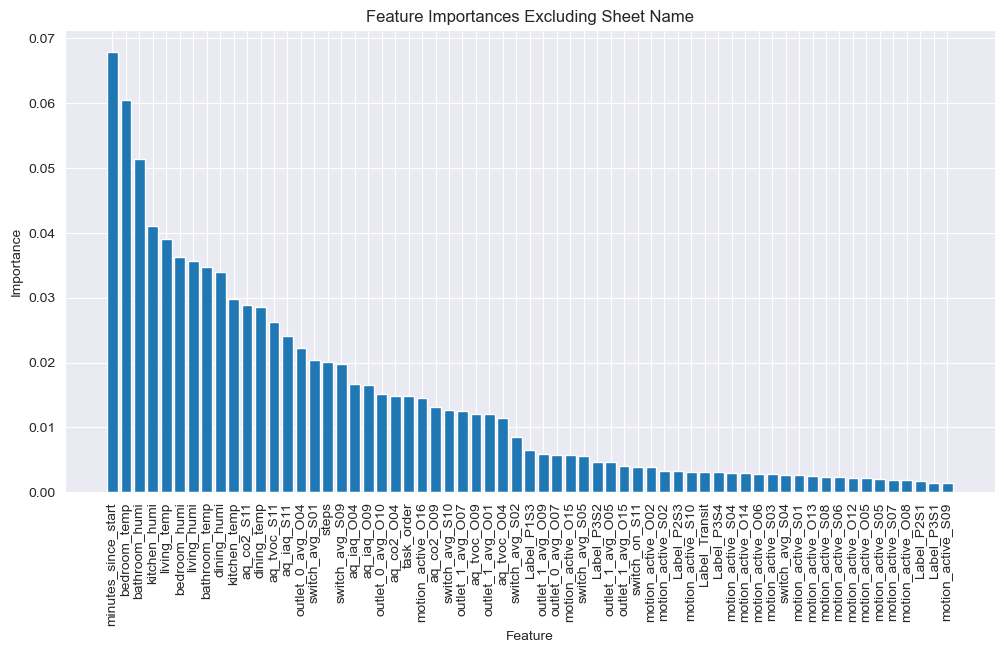

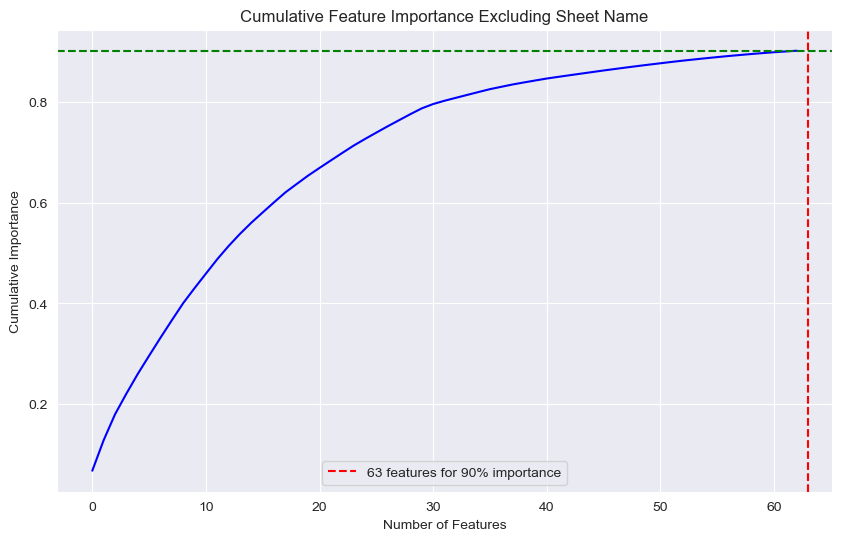

In [6]:
import matplotlib.pyplot as plt

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_processed, y_train)

# Get feature importances
importances = rf_model.feature_importances_
feature_names = X_train_processed.columns

# Exclude 'sheet_name' related features from importance analysis
filtered_importances, filtered_feature_names = zip(*((imp, name) for imp, name in zip(importances, feature_names) if not name.startswith('sheet_name_')))

# Convert to numpy arrays for further processing
filtered_importances = np.array(filtered_importances)
filtered_feature_names = np.array(filtered_feature_names)

# Sort the filtered feature importances in descending order
sorted_indices = np.argsort(filtered_importances)[::-1]

# Calculate cumulative importances
cumulative_importances = np.cumsum(filtered_importances[sorted_indices])

# Find the number of features needed for 90% of total importance
threshold = 0.90
n_features_threshold = np.where(cumulative_importances > threshold)[0][0] + 1

# Get the most important features
most_important_features = filtered_feature_names[sorted_indices][:n_features_threshold]

# Visualize the feature importances
plt.figure(figsize=(12, 6))
plt.bar(range(n_features_threshold), filtered_importances[sorted_indices][:n_features_threshold], align='center')
plt.xticks(range(n_features_threshold), most_important_features, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances Excluding Sheet Name')
plt.show()

# Visualize the cumulative importance
plt.figure(figsize=(10, 6))
plt.plot(range(n_features_threshold), cumulative_importances[:n_features_threshold], 'b-')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance Excluding Sheet Name')
plt.axvline(x=n_features_threshold, color='r', linestyle='--', label=f'{n_features_threshold} features for 90% importance')
plt.axhline(y=0.90, color='green', linestyle='--')
plt.legend()
plt.show()


The figure indicates that 63 features account for 90% of the total importance in your Random Forest model. This visualization is an effective way to communicate how many features are contributing to the majority of a model's predictive ability and helps in deciding which features to keep for model training.

The listed features represent the most significant predictors for the target variable 'hr_mean' as determined by the model.

Excellent, now that we have identified the most important features, you can proceed to train various machine learning models using only these features. This can help in improving model performance, reducing overfitting, and speeding up training time. Here's a general approach to run multiple models:

Select Important Features: Use the most important features identified from your RandomForestRegressor for training.

Choose Models to Train: Select a variety of machine learning models. Common choices include Linear Regression, Support Vector Machines, Decision Trees, Gradient Boosting, and more.

Train Each Model: Train each model on the same set of features.

Evaluate the Models: Evaluate each model's performance using appropriate metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared (R²).


Mean Absolute Error (MAE): This metric represents the average absolute difference between the actual and predicted values. It provides a straightforward interpretation of the average error magnitude but does not penalize large errors more than smaller ones.

Mean Squared Error (MSE): MSE is the average of the squared differences between the actual and predicted values. It gives a higher weight to larger errors compared to MAE, making it more sensitive to outliers. MSE is useful when large errors are particularly undesirable.

Root Mean Squared Error (RMSE): RMSE is the square root of MSE. It's in the same units as the dependent variable and is sensitive to large errors. RMSE is commonly used because it penalizes large errors more strongly than MAE and is easier to interpret in the same units as the response variable.

R-squared (R²): This is the proportion of the variance in the dependent variable that is predictable from the independent variables. It provides an indication of the goodness of fit of the model. An R² of 1 indicates that the regression predictions perfectly fit the data.


Justification of the Models Chosen

Linear Regression: This is one of the simplest and most interpretable models. It's a good starting point as it makes no complex assumptions about the data structure. If this model performs well, it suggests a linear relationship between the features and the target variable.

Ridge Regression: This is a variation of linear regression that includes L2 regularization. It helps in handling multicollinearity (high correlation among features) and in preventing overfitting, especially useful when the number of features is high.

Lasso Regression: Similar to Ridge, Lasso includes L1 regularization. It not only helps in preventing overfitting but can also perform feature selection by shrinking coefficients for less important features to zero.

Support Vector Regression (SVR): SVR can efficiently perform linear and non-linear regression. It is robust to outliers and can model complex relationships, making it a powerful tool when linear models fall short.

Decision Tree Regressor: This model is useful for capturing non-linear relationships. It's interpretable and can handle varied types of data. However, it can be prone to overfitting, especially with many features.

Gradient Boosting Regressor: This is an ensemble method that builds multiple weak predictive models (typically decision trees) to create a stronger model. Gradient Boosting is effective in capturing complex relationships in data and often delivers high predictive accuracy.

In [7]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Function to train and evaluate a model
def train_evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    mae = mean_absolute_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_pred)
 

    return mae, mse, rmse, r2


# Selecting the important features for training
X_train_selected = X_train_processed[most_important_features]
X_val_selected = X_val_processed[most_important_features]
X_test_selected = X_test_processed[most_important_features]

# Rest of the code remains the same


# List of models to train
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Support Vector Regression": SVR(),
    "Decision Tree": DecisionTreeRegressor(),
    "Gradient Boosting": GradientBoostingRegressor()
}

# Train and evaluate each model
model_results = {}
for name, model in models.items():
    mae, mse, rmse, r2 = train_evaluate_model(model, X_train_selected, y_train, X_val_selected, y_val)
    model_results[name] = {"MAE": mae, "MSE": mse, "RMSE": rmse, "R²": r2}

# Display the results
for model_name, results in model_results.items():
    print(f"Results for {model_name}:")
    for metric, value in results.items():
        print(f"  {metric}: {value}")
    print()


Results for Linear Regression:
  MAE: 8.545521803893369
  MSE: 133.38288402675323
  RMSE: 11.549150792450206
  R²: 0.11786161645326065

Results for Ridge Regression:
  MAE: 8.510334911862682
  MSE: 133.10060612197665
  RMSE: 11.536923598688546
  R²: 0.119728483978637

Results for Lasso Regression:
  MAE: 8.83734968577659
  MSE: 143.2286570338927
  RMSE: 11.9678175551724
  R²: 0.052745808314458964

Results for Support Vector Regression:
  MAE: 8.258296571139596
  MSE: 134.60705507666881
  RMSE: 11.602028058777863
  R²: 0.10976546319464142

Results for Decision Tree:
  MAE: 8.892119618696187
  MSE: 159.76751813268754
  RMSE: 12.639917647385506
  R²: -0.05663527383749578

Results for Gradient Boosting:
  MAE: 7.756464375218266
  MSE: 112.18908372179023
  RMSE: 10.591934843162047
  R²: 0.2580285117685738


Based on the performance metrics from the machine learning models you have run, it seems that Gradient Boosting performs the best among the models tried, with the lowest Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and the highest R-squared (R²) value. This suggests that your dataset may benefit from models that can capture more complex, non-linear relationships in the data.

Given this, we will consider experimenting with other advanced ensemble methods and non-linear models.

Random Forest Regressor: An ensemble method similar to Gradient Boosting but uses averaging of decision trees, which can help improve accuracy and control overfitting.

Extra Trees Regressor (Extremely Randomized Trees): Similar to Random Forests but randomizes the thresholds for splitting, which can help in discovering more robust patterns.

XGBoost: An efficient implementation of Gradient Boosting that is often used in machine learning competitions for its performance and speed.

Neural Networks: Deep learning models can capture highly complex patterns, although they might require more data and computational resources.

In [8]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

# Additional models to train
additional_models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Extra Trees": ExtraTreesRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "Neural Network": MLPRegressor(random_state=42)
}

# Train and evaluate each additional model
for name, model in additional_models.items():
    mae, mse, rmse, r2 = train_evaluate_model(model, X_train_selected, y_train, X_val_selected, y_val)
    model_results[name] = {"MAE": mae, "MSE": mse, "RMSE": rmse, "R²": r2}

# Display the results for additional models
for model_name, results in model_results.items():
    print(f"Results for {model_name}:")
    for metric, value in results.items():
        print(f"  {metric}: {value}")
    print()


Results for Linear Regression:
  MAE: 8.545521803893369
  MSE: 133.38288402675323
  RMSE: 11.549150792450206
  R²: 0.11786161645326065

Results for Ridge Regression:
  MAE: 8.510334911862682
  MSE: 133.10060612197665
  RMSE: 11.536923598688546
  R²: 0.119728483978637

Results for Lasso Regression:
  MAE: 8.83734968577659
  MSE: 143.2286570338927
  RMSE: 11.9678175551724
  R²: 0.052745808314458964

Results for Support Vector Regression:
  MAE: 8.258296571139596
  MSE: 134.60705507666881
  RMSE: 11.602028058777863
  R²: 0.10976546319464142

Results for Decision Tree:
  MAE: 8.892119618696187
  MSE: 159.76751813268754
  RMSE: 12.639917647385506
  R²: -0.05663527383749578

Results for Gradient Boosting:
  MAE: 7.756464375218266
  MSE: 112.18908372179023
  RMSE: 10.591934843162047
  R²: 0.2580285117685738

Results for Random Forest:
  MAE: 6.933641168511686
  MSE: 92.06532002537315
  RMSE: 9.595067484148986
  R²: 0.39111863429488913

Results for Extra Trees:
  MAE: 7.243742675276752
  MSE: 

/Users/ashishsaragadam/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Based on the results you've shared, it looks like ensemble methods, particularly Random Forest and XGBoost, are performing quite well on your dataset. These models are generally effective for a wide range of regression tasks due to their ability to capture complex patterns and reduce overfitting.

Given the success of these models, exploring advanced neural network architectures like Long Short-Term Memory (LSTM) and Gated Recurrent Units (GRUs) could be worthwhile, especially if the data has temporal or sequential characteristics. These models are part of recurrent neural networks (RNNs), which are designed to work with sequence data. They can be particularly effective if your dataset involves time series data or if the order of the data points is important.

K-Nearest Neighbors (KNN) uses the x closest neighbors. You can tune n_neighbors based on your dataset.
Support Vector Regression (SVR) with RBF Kernel: Here, SVR is used with a Radial Basis Function (RBF) kernel. You can experiment with other kernels like linear or poly.
AdaBoost Regressor: This model combines multiple weak learners into a stronger model. n_estimators represents the number of weak learners.
Bagging Regressor: This is an ensemble method that fits base regressors on random subsets of the original dataset.
PLS Regression: Partial Least Squares Regression is used when there are many features, and they are highly collinear.
Elastic Net Regression: This model combines features of Lasso and Ridge regression.


In [9]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import ElasticNet

# Function to train and evaluate a model (assuming it's already defined)
# ...

# Additional models to train
additional_models = {
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=5),
    "Support Vector Regression (RBF Kernel)": SVR(kernel='rbf'),
    "AdaBoost Regressor": AdaBoostRegressor(n_estimators=100, random_state=42),
    "Bagging Regressor": BaggingRegressor(n_estimators=100, random_state=42),
    "PLS Regression": PLSRegression(n_components=2),
    "Elastic Net Regression": ElasticNet(random_state=42)
}

# Train and evaluate each additional model
for name, model in additional_models.items():
    mae, mse, rmse, r2 = train_evaluate_model(model, X_train_selected, y_train, X_val_selected, y_val)
    model_results[name] = {"MAE": mae, "MSE": mse, "RMSE": rmse, "R²": r2}

# Display the results for additional models
for model_name, results in model_results.items():
    print(f"Results for {model_name}:")
    for metric, value in results.items():
        print(f"  {metric}: {value}")
    print()


Results for Linear Regression:
  MAE: 8.545521803893369
  MSE: 133.38288402675323
  RMSE: 11.549150792450206
  R²: 0.11786161645326065

Results for Ridge Regression:
  MAE: 8.510334911862682
  MSE: 133.10060612197665
  RMSE: 11.536923598688546
  R²: 0.119728483978637

Results for Lasso Regression:
  MAE: 8.83734968577659
  MSE: 143.2286570338927
  RMSE: 11.9678175551724
  R²: 0.052745808314458964

Results for Support Vector Regression:
  MAE: 8.258296571139596
  MSE: 134.60705507666881
  RMSE: 11.602028058777863
  R²: 0.10976546319464142

Results for Decision Tree:
  MAE: 8.892119618696187
  MSE: 159.76751813268754
  RMSE: 12.639917647385506
  R²: -0.05663527383749578

Results for Gradient Boosting:
  MAE: 7.756464375218266
  MSE: 112.18908372179023
  RMSE: 10.591934843162047
  R²: 0.2580285117685738

Results for Random Forest:
  MAE: 6.933641168511686
  MSE: 92.06532002537315
  RMSE: 9.595067484148986
  R²: 0.39111863429488913

Results for Extra Trees:
  MAE: 7.243742675276752
  MSE: 


Given the results from a wide range of models you've tested, it's clear that ensemble methods like Random Forest and Bagging Regressors are performing particularly well on your dataset. These methods are effective in capturing complex relationships in the data without overfitting, which might be why they are outperforming other models.

Considering this, here are a few additional models and approaches you might explore:

**Advanced Ensemble Techniques:**


Stacking Regressor: This method stacks the output of individual estimators and uses a final regressor to compute the final prediction. This can help blend the strengths of various individual models.
CatBoost Regressor: An algorithm that handles categorical features well and is robust to overfitting, similar to Gradient Boosting but often with better performance.

**Time Series Specific Models (if your data has a temporal component):8*

ARIMA (AutoRegressive Integrated Moving Average): Effective for time-series forecasting.
Prophet: Developed by Facebook, it's useful for time series data, especially with seasonal patterns.

**Advanced Neural Networks:**

Convolutional Neural Networks (CNNs) for Regression: While commonly used in image processing, CNNs can be adapted for regression tasks.
Recurrent Neural Networks (RNNs): If your data has a temporal or sequential aspect, RNNs, beyond LSTMs and GRUs, can be explored.

**Bayesian Regression Methods:**

Bayesian Ridge Regression: Incorporates Bayesian inference in the regression model, providing a probabilistic approach to estimating a linear model.

In [10]:
from sklearn.ensemble import StackingRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import BayesianRidge

# Define base models for stacking
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=100, random_state=42))
]

# Stacking Regressor
stacking_model = StackingRegressor(estimators=base_models, final_estimator=Ridge(), cv=5)

# CatBoost Regressor
catboost_model = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=5, silent=True, random_state=42)

# Bayesian Ridge Regression
bayesian_ridge_model = BayesianRidge()

# Adding new models to the existing models dictionary
additional_models = {
    "Stacking Regressor": stacking_model,
    "CatBoost Regressor": catboost_model,
    "Bayesian Ridge Regression": bayesian_ridge_model
}

# Train and evaluate each additional model
for name, model in additional_models.items():
    mae, mse, rmse, r2 = train_evaluate_model(model, X_train_selected, y_train, X_val_selected, y_val)
    model_results[name] = {"MAE": mae, "MSE": mse, "RMSE": rmse, "R²": r2}

# Display the results for additional models
for model_name, results in model_results.items():
    print(f"Results for {model_name}:")
    for metric, value in results.items():
        print(f"  {metric}: {value}")
    print()


Results for Linear Regression:
  MAE: 8.545521803893369
  MSE: 133.38288402675323
  RMSE: 11.549150792450206
  R²: 0.11786161645326065

Results for Ridge Regression:
  MAE: 8.510334911862682
  MSE: 133.10060612197665
  RMSE: 11.536923598688546
  R²: 0.119728483978637

Results for Lasso Regression:
  MAE: 8.83734968577659
  MSE: 143.2286570338927
  RMSE: 11.9678175551724
  R²: 0.052745808314458964

Results for Support Vector Regression:
  MAE: 8.258296571139596
  MSE: 134.60705507666881
  RMSE: 11.602028058777863
  R²: 0.10976546319464142

Results for Decision Tree:
  MAE: 8.892119618696187
  MSE: 159.76751813268754
  RMSE: 12.639917647385506
  R²: -0.05663527383749578

Results for Gradient Boosting:
  MAE: 7.756464375218266
  MSE: 112.18908372179023
  RMSE: 10.591934843162047
  R²: 0.2580285117685738

Results for Random Forest:
  MAE: 6.933641168511686
  MSE: 92.06532002537315
  RMSE: 9.595067484148986
  R²: 0.39111863429488913

Results for Extra Trees:
  MAE: 7.243742675276752
  MSE: 

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Convert the data to float32
X_train_float = X_train_selected.astype('float32')
X_val_float = X_val_selected.astype('float32')

# Reshape data for LSTM [samples, time steps, features]
X_train_reshaped = np.reshape(X_train_float.values, (X_train_float.shape[0], 1, X_train_float.shape[1]))
X_val_reshaped = np.reshape(X_val_float.values, (X_val_float.shape[0], 1, X_val_float.shape[1]))

# complex LSTM model with hyperparameter tuning
def build_lstm_model(input_shape, units=50, activation='tanh', dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units, activation=activation, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # Output layer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

lstm_model = build_lstm_model(input_shape=(1, X_train_selected.shape[1]), units=164, activation='tanh', dropout_rate=0.2, learning_rate=0.001)

# Train the model (adjust batch_size and epochs as needed)
lstm_model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_data=(X_val_reshaped, y_val))

# Evaluate the model

# Evaluate the model
y_pred = lstm_model.predict(X_val_reshaped)
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print(f"LSTM Results:")
print(f"  MAE: {mae}")
print(f"  MSE: {mse}")
print(f"  RMSE: {rmse}")
print(f"  R²: {r2}")


Epoch 1/50
79/79 [==============================] - 2s 7ms/step - loss: 6401.4907 - val_loss: 4470.4004
Epoch 2/50
79/79 [==============================] - 0s 4ms/step - loss: 3082.9631 - val_loss: 2258.4170
Epoch 3/50
79/79 [==============================] - 0s 4ms/step - loss: 1788.9072 - val_loss: 1402.6655
Epoch 4/50
79/79 [==============================] - 0s 4ms/step - loss: 1121.4547 - val_loss: 887.4371
Epoch 5/50
79/79 [==============================] - 0s 4ms/step - loss: 712.5917 - val_loss: 569.2264
Epoch 6/50
79/79 [==============================] - 0s 4ms/step - loss: 474.1059 - val_loss: 377.9763
Epoch 7/50
79/79 [==============================] - 0s 4ms/step - loss: 327.5558 - val_loss: 267.7183
Epoch 8/50
79/79 [==============================] - 0s 4ms/step - loss: 243.9263 - val_loss: 208.6765
Epoch 9/50
79/79 [==============================] - 0s 4ms/step - loss: 205.3728 - val_loss: 178.5324
Epoch 10/50
79/79 [==============================] - 0s 4ms/step - loss: 18

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Convert data to float32 and reshape for RNN
X_train_float = X_train_selected.astype('float32')
X_val_float = X_val_selected.astype('float32')
X_train_reshaped = X_train_float.values.reshape((X_train_float.shape[0], 1, X_train_float.shape[1]))
X_val_reshaped = X_val_float.values.reshape((X_val_float.shape[0], 1, X_val_float.shape[1]))

# Define the GRU model
def build_gru_model(input_shape, units=50, activation='tanh', dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(GRU(units, activation=activation, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(GRU(units, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # Output layer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Build and train the GRU model
gru_model = build_gru_model(input_shape=(1, X_train_selected.shape[1]), units=164, activation='tanh', dropout_rate=0.2, learning_rate=0.001)
gru_model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_data=(X_val_reshaped, y_val))

# Evaluate the model
y_pred = gru_model.predict(X_val_reshaped)
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print(f"GRU Model Evaluation:")
print(f"  MAE: {mae}")
print(f"  MSE: {mse}")
print(f"  RMSE: {rmse}")
print(f"  R²: {r2}")


Epoch 1/50
79/79 [==============================] - 2s 6ms/step - loss: 5921.7886 - val_loss: 3425.4187
Epoch 2/50
79/79 [==============================] - 0s 4ms/step - loss: 2197.4792 - val_loss: 1460.6022
Epoch 3/50
79/79 [==============================] - 0s 4ms/step - loss: 1065.4305 - val_loss: 755.7811
Epoch 4/50
79/79 [==============================] - 0s 4ms/step - loss: 568.3102 - val_loss: 412.9808
Epoch 5/50
79/79 [==============================] - 0s 4ms/step - loss: 331.7742 - val_loss: 255.1788
Epoch 6/50
79/79 [==============================] - 0s 4ms/step - loss: 227.1599 - val_loss: 188.6281
Epoch 7/50
79/79 [==============================] - 0s 4ms/step - loss: 184.9399 - val_loss: 163.1917
Epoch 8/50
79/79 [==============================] - 0s 4ms/step - loss: 173.4339 - val_loss: 155.0277
Epoch 9/50
79/79 [==============================] - 0s 4ms/step - loss: 170.0574 - val_loss: 152.1530
Epoch 10/50
79/79 [==============================] - 0s 4ms/step - loss: 167.

Based off of the poor results of both RNNs and LSTM, it is quite evident that they do not work well with this data, now we will move on with visualization

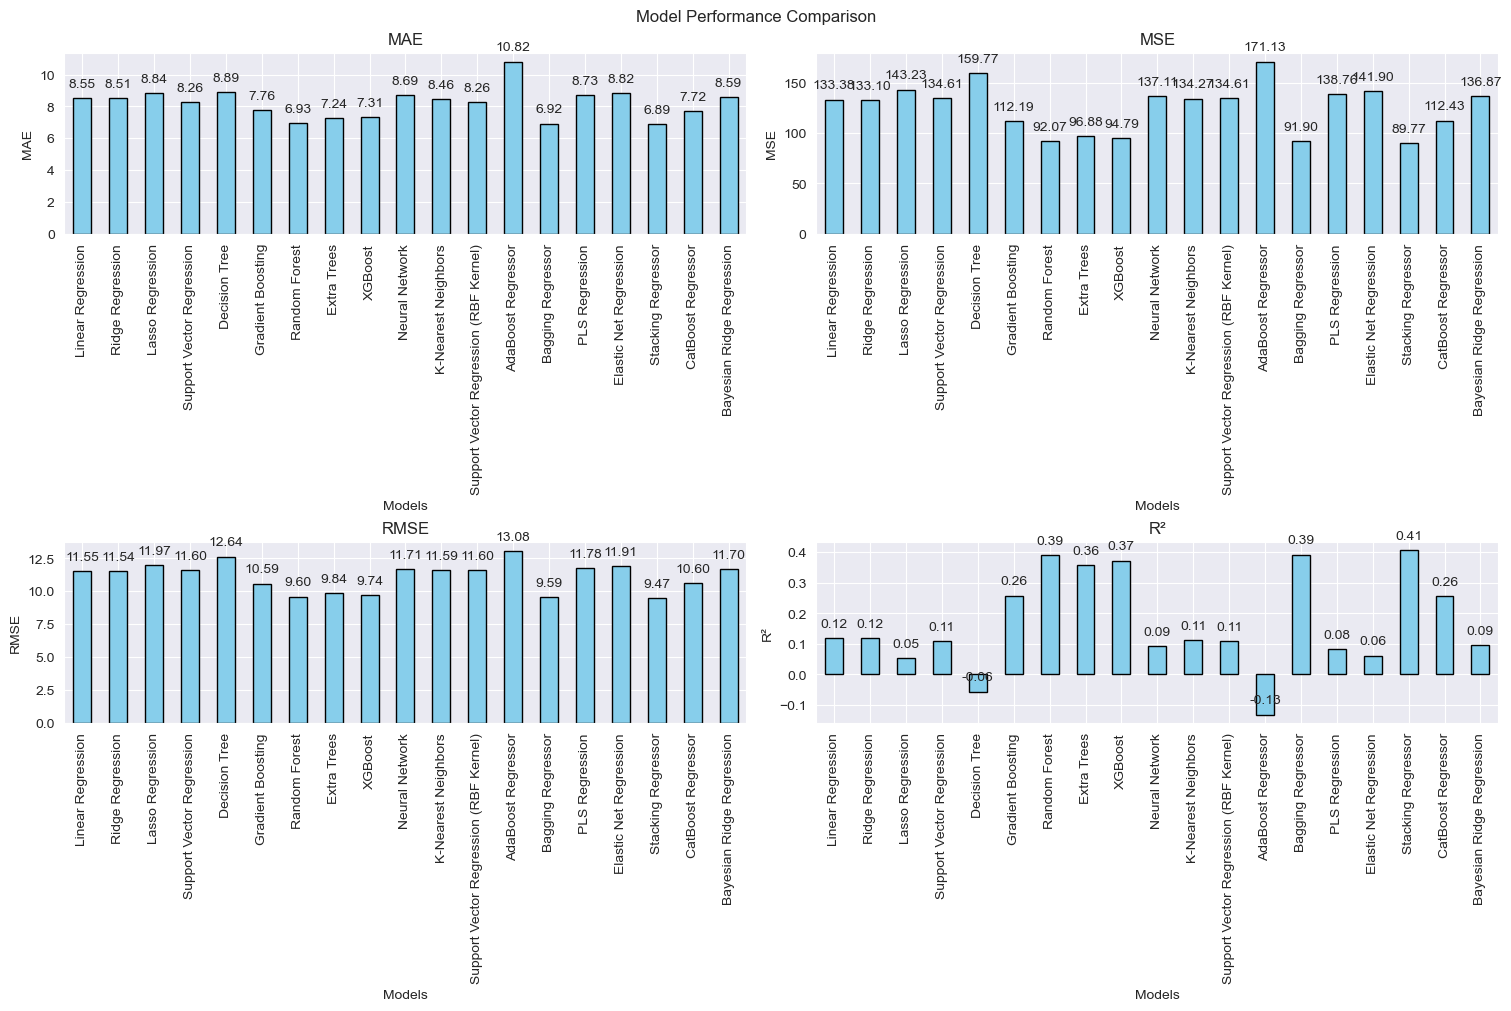

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'model_results' is a dictionary containing your models' performance metrics
# Convert the results to a DataFrame for easier plotting
results_df = pd.DataFrame(model_results).T  # Transpose to have models as rows

# Plot for each metric
metrics = ['MAE', 'MSE', 'RMSE', 'R²']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), constrained_layout=True)
axes = axes.flatten()  # Flatten to easily iterate

for i, metric in enumerate(metrics):
    results_df[metric].plot(kind='bar', ax=axes[i], color='skyblue', edgecolor='black')
    axes[i].set_title(metric)
    axes[i].set_ylabel(metric)
    axes[i].set_xlabel('Models')
    for p in axes[i].patches:
        axes[i].annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.suptitle('Model Performance Comparison')
plt.show()


As you can see from the metrics, the stacking regressor is the best model we built so far. The Stacking Regressor is a powerful ensemble method that combines the predictions of multiple base models using a final estimator. The results suggest that the combination of these models is capturing the complexity of the dataset effectively. Now lets try to tune the best models

The performance of the stacking regressor heavily depends on the base models. We will now consider fine-tuning the hyperparameters of the RandomForest and XGBoost models. This can be done using grid search or random search methods. But before we do, lets first re-run the base model for the stacked regressor below. 

In [12]:
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge

# Define base models for stacking
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=100, random_state=42))
]

# Stacking Regressor with Ridge as the final estimator
stacking_model = StackingRegressor(estimators=base_models, final_estimator=Ridge(), cv=5)

# Train and evaluate the Stacking Regressor
mae, mse, rmse, r2 = train_evaluate_model(stacking_model, X_train_selected, y_train, X_val_selected, y_val)

print(f"Stacking Regressor Evaluation:")
print(f"  MAE: {mae}")
print(f"  MSE: {mse}")
print(f"  RMSE: {rmse}")
print(f"  R²: {r2}")


Stacking Regressor Evaluation:
  MAE: 6.894038777682657
  MSE: 89.77053826040829
  RMSE: 9.474731566667643
  R²: 0.4062953572418351


Tuning Base Models: The performance of the stacking regressor heavily depends on the base models. Consider fine-tuning the hyperparameters of the RandomForest and XGBoost models. This can be done using grid search or random search methods.

What are Hyperparameters?

Hyperparameters are the configuration settings used to structure a machine learning model. These parameters are not learned from the data but are set prior to the training process. They can significantly influence the performance of a model.

RandomForestRegressor Parameters:

n_estimators: Number of trees in the forest.
max_depth: Maximum depth of the trees.
min_samples_split: Minimum number of samples required to split an internal node.
min_samples_leaf: Minimum number of samples required to be at a leaf node.
max_features: Number of features to consider when looking for the best split.


XGBRegressor Parameters:

n_estimators: Number of gradient boosted trees.
learning_rate: Step size shrinkage used in update to prevent overfitting.
max_depth: Maximum depth of a tree.
subsample: Subsample ratio of the training instances.
colsample_bytree: Subsample ratio of columns when constructing each tree.

Hyperparameter Tuning Methods
Grid Search:

How it Works: Tests every possible combination of hyperparameters specified in a grid.
Pros: Exhaustive and thorough, ensuring the best combination is found.
Cons: Computationally expensive and time-consuming, especially with a large number of hyperparameters.

Using Grid Search
Grid Search is a method where you define a grid of hyperparameters and exhaustively search through them. Here's an example using GridSearchCV from scikit-learn:

In [13]:
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define base models for stacking
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=100, random_state=42))
]

# Stacking Regressor with Ridge as the final estimator
stacking_model = StackingRegressor(estimators=base_models, final_estimator=Ridge(), cv=5)

# Define the parameter grid
# Define the parameter grid (with corrected max_features for RandomForestRegressor)
param_grid = {
    'rf__n_estimators': [100, 200],  
    'rf__max_depth': [None, 20],   
    'rf__min_samples_split': [2, 5], 
    'rf__min_samples_leaf': [1, 2],
    'rf__max_features': ['sqrt', 'log2'],  

    'xgb__n_estimators': [100, 200], 
    'xgb__learning_rate': [0.05, 0.1], 
    'xgb__max_depth': [3, 6], 
    'xgb__subsample': [0.7, 1.0], 
    'xgb__colsample_bytree': [0.7, 1.0]
}

# Initialize GridSearchCV with the updated grid
grid_search = GridSearchCV(estimator=stacking_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit to the training data
grid_search.fit(X_train_selected, y_train)

# Print the best parameters
print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 1024 candidates, totalling 5120 fits
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, xgb__colsample_bytree=0.7, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.7; total time=   3.3s
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, xgb__colsample_bytree=0.7, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.7; total time=   3.6s
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, xgb__colsample_bytree=0.7, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__n_estimators=100, xgb__subsample=0.7; total time=   4.7s
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, xgb__colsample_bytree=0.7, xgb__learning_rate=0

/Users/ashishsaragadam/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END rf__max_depth=20, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200, xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=200, xgb__subsample=0.7; total time=   9.3s
[CV] END rf__max_depth=20, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100, xgb__colsample_bytree=0.7, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.7; total time=   2.9s
[CV] END rf__max_depth=20, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100, xgb__colsample_bytree=0.7, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.7; total time=   3.3s
[CV] END rf__max_depth=20, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100, xgb__colsample_bytree=0.7, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__n_estimators=100, xgb__subsample=0.7; total ti

In [14]:
# Update the stacking model with the best parameters
stacking_model.set_params(**grid_search.best_params_)

# Train the updated model on the selected training data
stacking_model.fit(X_train_selected, y_train)

# Predict on the validation set
y_val_pred = stacking_model.predict(X_val_selected)

# Evaluate the model on the validation set
mae = mean_absolute_error(y_val, y_val_pred)
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_val_pred)

print("Evaluation on Validation Set with Best Parameters:")
print(f"  MAE: {mae}")
print(f"  MSE: {mse}")
print(f"  RMSE: {rmse}")
print(f"  R²: {r2}")


Evaluation on Validation Set with Best Parameters:
  MAE: 6.93404648163292
  MSE: 90.22908851397294
  RMSE: 9.498899331710644
  R²: 0.4032626984235317


approach to hyperparameter tuning using GridSearchCV for the Stacking Regressor is a common method to optimize model performance. However, it's not unusual for hyperparameter tuning to sometimes result in suboptimal performance compared to the default settings, especially in complex models like stacking ensembles. Here are a few insights and suggestions for this scenario:

Complexity of Stacked Models: Stacking ensembles are inherently complex since they combine multiple models. The interactions between hyperparameters of different models can be highly non-linear and unpredictable.

Overfitting: There's a risk of overfitting when tuning hyperparameters, especially with complex models and many hyperparameters. This can lead to worse performance on unseen data, even if the performance on the training set improves.

In [ ]:
# Align the test data features with the training data
# Retain only those columns in the test set that are present in the training set
# Identify missing columns in the test data
missing_cols = [col for col in X_train_processed.columns if col not in X_test_processed.columns]

# Add missing columns to the test data
for col in missing_cols:
    X_test_processed[col] = 0


X_test_aligned = X_test_processed[X_train_processed.columns]

# Make predictions on the aligned test data
y_pred = stacking_model.predict(X_test_aligned)

# Evaluate the model's performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Test Data Evaluation:")
print(f"  MAE: {mae}")
print(f"  MSE: {mse}")
print(f"  RMSE: {rmse}")
print(f"  R²: {r2}")
